In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Importing librares

In [2]:
import sys
sys.path.append("../src/")

In [3]:
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt

In [4]:
from tqdm import tqdm
from gensim.models import word2vec

from textDataset import *
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
cpu_count = 2*multiprocessing.cpu_count()-1
print('Number of CPUs: {}'.format(cpu_count))

Number of CPUs: 7


In [6]:
path2data = '../Assignment-03/'

# Text processing

In [7]:
path2data = '../../'

text = {
        'train': TextDataset(path2data, extension='.csv', sep=',', is_train = True),
}    

In [8]:
col = 'headline_text'
text['train'].process_data(col = col, remove_stopw = True, remove_tags=True)

In [9]:
text['train'].data.head(2)

,publish_date,headline_text,subject,headline_text_data
0,20030303,unhooked brakes to blame for taiwan train disa...,news_headlines,"[unhooked, brakes, blame, taiwan, train, disas..."
1,20030918,oldest prisoner in tas released citing health,news_headlines,"[oldest, prisoner, tas, released, citing, health]"


# Dividing data by published year

In [24]:
text['train'].data.publish_date = pd.to_datetime(text['train'].data.publish_date.astype(str),format='%Y-%m-%d')

In [25]:
text['train'].data.publish_date.describe()

count                 1000001
unique                   5422
top       2012-10-17 00:00:00
freq                      375
first     2003-02-19 00:00:00
last      2017-12-31 00:00:00
Name: publish_date, dtype: object

In [29]:
text['train'].data.publish_date.dt.year.value_counts()

2013    81016
2012    78547
2014    73361
2008    71591
2015    70004
2011    69919
2007    69431
2009    68867
2010    67715
2005    66320
2004    65975
2006    61568
2003    59343
2016    52162
2017    44182
Name: publish_date, dtype: int64

In [33]:
years = text['train'].data.publish_date.dt.year.unique().tolist()

text_yearly ={str(year):text['train'].data[text['train'].data.publish_date.dt.year == year] for year in years}

In [35]:
for year in years: 
    print(f'{year} : {text_yearly[str(year)].shape}')

2003 : (59343, 4)
2004 : (65975, 4)
2005 : (66320, 4)
2006 : (61568, 4)
2007 : (69431, 4)
2008 : (71591, 4)
2009 : (68867, 4)
2010 : (67715, 4)
2011 : (69919, 4)
2012 : (78547, 4)
2013 : (81016, 4)
2014 : (73361, 4)
2015 : (70004, 4)
2016 : (52162, 4)
2017 : (44182, 4)


# Analyzing whole data

In [10]:
sentences = { 'train': text['train'].data[col + '_data'].values}
X_train = sentences['train']

In [46]:
X_train[0]

['unhooked', 'brakes', 'blame', 'taiwan', 'train', 'disaster']

In [12]:
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 50   # Minimum word count                        
num_workers = cpu_count  # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words



W2Vmodel = word2vec.Word2Vec(workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)


W2Vmodel.build_vocab([x for x in tqdm(X_train)])
W2Vmodel.train([x for x in tqdm(X_train)], \
            total_examples=W2Vmodel.corpus_count, epochs=W2Vmodel.epochs)



100%|██████████| 1000001/1000001 [00:00<00:00, 2300444.37it/s]


(23973751, 26623945)

In [13]:
print ('Building tf-idf matrix ...')
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x for x in X_train])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print ('vocab size : {}'.format(len(tfidf)))

Building tf-idf matrix ...
vocab size : 25591


In [33]:
def buildWordVector(model, tfidf, tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: 
            continue
    if count != 0:
        vec /= count
    return vec

In [34]:
f_train = np.concatenate([buildWordVector(W2Vmodel, tfidf, z, num_features) for z in map(lambda x: x, X_train)])

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [35]:
print('Shape of train features:: {}'.format(f_train.shape))

Shape of train features:: (1000001, 300)


In [40]:
# Saving train features : 
np.save('./f_train.npy',f_train)


In [ ]:
def elbow_rule(f_train, max_nb_cluster = 10, distortions_method='euclidean', plot=True):

    # k means determine k
    distortions = []

    for k in range(1,max_nb_cluster):
        print('Training K-means models for {} cluster/s...'.format(k))
        kmeanModel = KMeans(n_clusters=k).fit(f_train)
        kmeanModel.fit(f_train)
        if distortions_method == 'euclidean':
            distortions.append(sum(np.min(cdist(f_train, kmeanModel.cluster_centers_, 'euclidean'), \
                                          axis=1)) / f_train.shape[0])
        #elif other distortion evaluation
        
    if plot:
        # Plot the elbow
        plt.figure(figsize=(10,5))
        plt.plot(range(1,max_nb_cluster), distortions, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Distortion')
        plt.title('Elbow Method')
        plt.show()

In [ ]:
elbow_rule(f_train)

In [14]:
# Loading train features : 
f_train = np.load('./f_train.npy')
f_train.shape

(1000001, 300)

Elbow rule using within cluster sum of squares:

$$WCSS = \sum_{j}^k\sum_{P_i \ \in \ C_j} \mbox{distance}(P_i,\mathbf{C}_j)$$

Where $k$ is the number of total clusters, $P_i$ is a point belonging to cluster $C_j$, $\mathbf{C}_j$ is the centroid of cluster $j$ and distance is the type distance chose on the kmeans algorithm (i.e: euclidian, manhattan...).

In [ ]:
from sklearn.metrics import silhouette_score,calinski_harabaz_score

For k clusters, the Calinski-Harabaz score s is given as the ratio of the between-clusters dispersion mean and the within-cluster dispersion:

$$ s(k) = \frac{Tr(B_k)}{Tr(W_k)} \times \frac{N - k}{k -1}$$

where $B_K$ is the between group dispersion matrix and $W_K$ is the within-cluster dispersion matrix defined by:

$$W_k = \sum_{q=1}^k\sum_{x \ \in \ C_q} (x - c_q)(x - c_q)^T$$

$$B_k = \sum_{q=1}\eta_q(c_q - c)(c_q - c)^T$$

with $N$ be the number of points in our data, $C_q$ be the set of points in cluster $q$, $c_q$ be the center of cluster $q$, $c$ be the center of $E$, $\eta_q$ be the number of points in cluster $q$.

In [15]:
from sklearn.cluster import KMeans,MiniBatchKMeans

In [30]:
wcss = []
cali = []
kmax = 18
for i in range(2, kmax):
    kmeans = MiniBatchKMeans(n_clusters = i, init = 'k-means++',
                             n_init=1,init_size= int(1e3),
                             random_state = 42,batch_size=int(1e3))
    kmeans.fit(f_train)
    wcss.append(kmeans.inertia_)
    ypred = kmeans.predict(f_train)
    cali.append(calinski_harabaz_score(f_train,ypred))

        

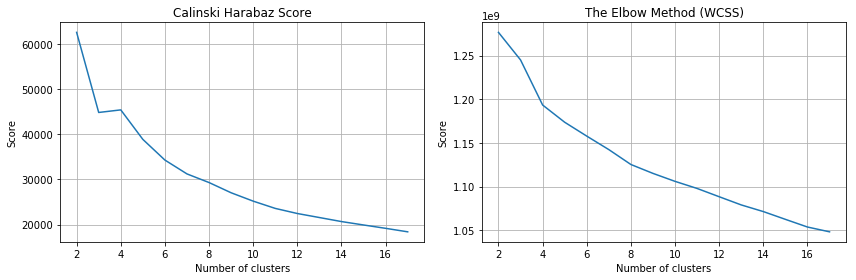

In [32]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(2, kmax), cali)
plt.title('Calinski Harabaz Score')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.grid()


plt.subplot(1, 2, 2)
plt.plot(range(2, kmax), wcss)
plt.title('The Elbow Method (WCSS)')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.grid()



plt.tight_layout()
plt.show()

# Visualizing clusters

In [16]:
kmeans = MiniBatchKMeans(n_clusters = 4, init = 'k-means++',
                         n_init=1,init_size= int(1e3),
                         random_state = 42,batch_size=int(1e3))
kmeans.fit(f_train)
ypred = kmeans.predict(f_train)

In [20]:
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA


def plot_pca(f_train, y_train, nb_clusters = 4):

    palette = np.array(sns.color_palette("hls", nb_clusters))

    pca = PCA(n_components=3)
    result = pca.fit_transform(f_train)
    

    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(result[:, 0], result[:, 1],result[:, 2],
               s=40, c=palette[ypred.astype(np.int)])

    #    plt.figure(figsize=(8, 8))     
    #    plt.scatter(result[:, 0], result[:, 1], lw=0, s=40,
    #                    c=palette[y_train.astype(np.int)])

    plt.title('Visualization PCA')
    plt.grid()
    plt.show()

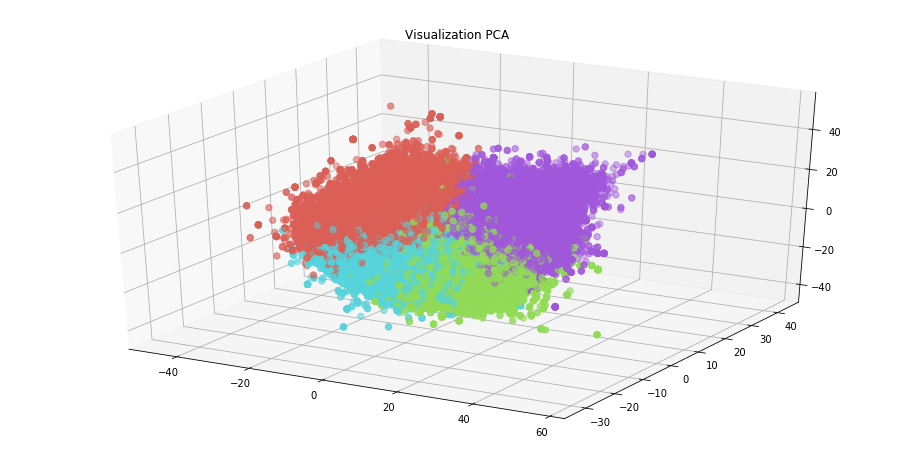

In [26]:
plot_pca(f_train, ypred)

## Words visualization using t-SNE

In [71]:
import bokeh.plotting as bp
from sklearn.manifold import TSNE
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook



def plot_tSNE(model,n_samples = 5000):

    
    #https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm

    output_notebook()
    fig = bp.figure(plot_width=700, plot_height=600, title="A map of " + str(n_samples) + " word vectors",
        tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
        x_axis_type=None, y_axis_type=None, min_border=1)


    word_vectors = [model[w] for w in model.wv.vocab.keys()][:n_samples]
    #word_vectors = [token for token in f_matrix_train][0:n_samples]
    word_centroid_map = dict(zip( W2Vmodel.wv.index2word, ypred ))



    tsne_model = TSNE(n_components=2, verbose=1, random_state=23)
    tsne_w2v = tsne_model.fit_transform(word_vectors)

    tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
    tsne_df['words'] = [k for k in model.wv.vocab.keys()][:n_samples]

    fig.scatter(x='x', y='y', source=tsne_df)
    hover = fig.select(dict(type=HoverTool))
    hover.tooltips={"word": "@words"}
    show(fig)

In [30]:
plot_tSNE(W2Vmodel)

Loading BokehJS ...

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.073s...
[t-SNE] Computed neighbors for 5000 samples in 16.234s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.250509
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.424141
[t-SNE] Error after 1000 iterations: 2.431944


# Visualizing words in clusters

In [69]:
# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number                                                                                            
word_centroid_map = dict(zip( W2Vmodel.wv.index2word, ypred ))

# For the first 5 clusters
for cluster in range(0,4):
    
    print (f"\n Cluster {cluster}")
    words = []
    for key, value in word_centroid_map.items():
        if( value == cluster ):
            words.append(key)

    print(f'{words[:10]}')


 Cluster 0
['police', 'says', 'govt', 'court', 'nsw', 'qld', 'crash', 'health', 'back', 'murder']

 Cluster 1
['new', 'man', 'council', 'interview', 'death', 'charged', 'report', 'car', 'calls', 'killed']

 Cluster 2
['us', 'fire', 'plan', 'water', 'wa', 'australian', 'woman', 'world', 'government', 'south']

 Cluster 3
['australia', 'sydney', 'call', 'win', 'home', 'missing', 'election', 'set', 'funding', 'group']
